# Lecture 4: Recurrent Neural Networks

**What you'll learn in this notebook (Part 1):**

1. Why vanilla neural networks can't handle sequences, and how RNNs fix this
2. Implementing an RNN from scratch in PyTorch
3. The vanishing gradient problem -- explained with the chain rule

**Task:** We'll build a character-level language model that learns to generate realistic human names.

## 1. From Vanilla Neural Networks to RNNs

### The Problem with Vanilla NNs

A feedforward (vanilla) neural network maps a **fixed-size** input to an output:

$$y = f(Wx + b)$$

This works for tasks like classifying an image (fixed 224x224 pixels). But what about **sequences** -- text, speech, time series -- where the input length varies?

**Example:** Given the characters `h e l l`, what comes next? A vanilla NN would need to see the entire sequence as one fixed vector, losing the order of characters.

### The RNN Idea: Add Memory

An RNN processes one element at a time and maintains a **hidden state** $h_t$ that summarises everything it has seen so far:

$$h_t = \tanh(W_h \cdot h_{t-1} + W_x \cdot x_t + b)$$

$$y_t = W_y \cdot h_t + b_y$$

| Symbol | Meaning |
|--------|---------|
| $x_t$ | Input at time step $t$ |
| $h_t$ | Hidden state (memory) at time step $t$ |
| $W_h$ | Weight matrix for hidden-to-hidden connections |
| $W_x$ | Weight matrix for input-to-hidden connections |
| $y_t$ | Output at time step $t$ |

**Key insight:** The **same** weights ($W_h$, $W_x$) are reused at every time step. This is called **weight sharing** -- it lets the network handle sequences of any length.

In [1]:
data = open('names.txt').read().splitlines()
data[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

### Language Modelling Task

**Goal:** Given a sequence of characters so far, predict the next character.

For example, if the name is "sophia":

| Step | Input so far | Predict |
|------|-------------|---------|
| 1 | `[S]` | s |
| 2 | `[S] s` | o |
| 3 | `[S] s o` | p |
| 4 | `[S] s o p` | h |
| 5 | `[S] s o p h` | i |
| 6 | `[S] s o p h i` | a |
| 7 | `[S] s o p h i a` | `[S]` (stop) |

We use `[S]` as a special start/stop token that tells the model when a name begins and ends.

Let's load a dataset of names to train on:

### Tokenisation

Before feeding text to a neural network, we convert characters to **integer indices**. We also define two special tokens:

- **`[S]`** -- Start/Stop token. Marks the beginning and end of each name.
- **`[PAD]`** -- Padding token. Used later to make all sequences the same length in a batch.

In [2]:
token_to_index = {tok: i for i, tok in enumerate('abcdefghijklmnopqrstuvwxyz')}
# Start/stop token
token_to_index['[S]'] = 26
# Padding token
token_to_index['[PAD]'] = 27

index_to_token = {i: tok for tok, i in token_to_index.items()}

### Preparing the Dataset for Next-Token Prediction

For each name, we create **(input, target)** pairs where the target is shifted by one position:

```
Name: "emma"

Tokens:  [S]  e  m  m  a  [S]
Input:   [S]  e  m  m  a        (everything except the last)
Target:   e   m  m  a  [S]      (everything except the first)
```

At each step, the model sees the tokens so far and learns to predict the next one.

In [3]:
import torch

def build_dataset(data):
    X, Y = [], []
    for item in data:
        tokens = ['[S]'] + list(item) + ['[S]']
        indices = [token_to_index[token] for token in tokens]
        X.append(indices[:-1])
        Y.append(indices[1:])
    return X, Y

# Split into train, dev, test
import random
random.seed(123)
random.shuffle(data)

n1 = int(0.8 * len(data))
n2 = int(0.9 * len(data))

X_train, Y_train = build_dataset(data[:n1])
X_dev, Y_dev = build_dataset(data[n1:n2])
X_test, Y_test = build_dataset(data[n2:])

len(X_train), len(Y_train)

(25626, 25626)

In [4]:
X_train[0], len(X_train[0]), X_train[1], len(X_train[1]), max(len(x) for x in X_train)

([26, 11, 20, 0, 13, 13], 6, [26, 18, 7, 0, 8, 13], 6, 16)

## 2. Implementing an RNN from Scratch

Let's implement the RNN cell ourselves. Recall the equation:

$$h_t = \tanh(W_h \cdot h_{t-1} + W_x \cdot x_t)$$

Our `RNNCell` has two linear layers:
- `Wh`: transforms the previous hidden state $h_{t-1}$
- `Wx`: transforms the current input $x_t$

We add them together and apply $\tanh$ to get the new hidden state.

In [5]:
# Write our own RNN cell 
import torch.nn as nn

class RNNCell(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        # Linear layer for hidden state: h_{t-1} -> h_t
        self.Wh = torch.nn.Linear(hidden_size, hidden_size)
        # Linear layer for input: x_t -> h_t
        self.Wx = torch.nn.Linear(input_size, hidden_size)
        # Activation function (Tanh is standard for RNNs)
        self.activation = torch.nn.Tanh()
        
    def forward(self, x, h):
        # x: input at current time step [batch_size, input_size]
        # h: hidden state from previous time step [batch_size, hidden_size]
        
        # Calculate new hidden state: h_t = tanh(W_h * h_{t-1} + W_x * x_t)
        h = self.activation(self.Wh(h) + self.Wx(x))
        return h


### The Full Language Model (RNNLM)

We wrap our `RNNCell` into a complete language model with three components:

1. **Embedding layer** -- converts each token index into a dense vector (e.g., index 5 -> a 32-dim vector)
2. **RNN loop** -- runs the `RNNCell` once per time step, updating the hidden state
3. **Output projection** -- maps each hidden state to logits over the vocabulary (one score per possible next character)

In [6]:

class RNNLM(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(RNNLM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.rnn = RNNCell(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size

    def forward(self, x, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(x.size(0))
        
        x = self.embedding(x)
        
        outs = []
        for i in range(x.size(1)):
            hidden = self.rnn(x[:, i:i+1], hidden)
            out = self.output(hidden)
            outs.append(out)
        
        outs = torch.cat(outs, dim=1)
        return outs, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, 1, self.hidden_size)

## 3. The Vanishing Gradient Problem

**Why does our RNN struggle with long sequences?** The answer lies in how gradients flow during backpropagation.

### Backpropagation Through Time (BPTT)

Training an RNN means computing $\frac{\partial L}{\partial W}$ -- how the loss changes as we tweak the weights. Since the RNN is "unrolled" across time, we apply the **chain rule** through every time step:

$$\frac{\partial L}{\partial W} = \sum_{t=1}^{T} \frac{\partial L_t}{\partial W}$$

For each $L_t$, we need to trace the gradient back through all previous hidden states:

$$\frac{\partial L_t}{\partial W} = \sum_{k=1}^{t} \frac{\partial L_t}{\partial h_t} \cdot \frac{\partial h_t}{\partial h_k} \cdot \frac{\partial h_k}{\partial W}$$

### The Chain of Jacobians

The critical term is $\frac{\partial h_t}{\partial h_k}$ -- how does hidden state at step $t$ depend on hidden state at step $k$?

Since $h_i = \tanh(W_h \cdot h_{i-1} + W_x \cdot x_i)$, by the chain rule:

$$\frac{\partial h_t}{\partial h_k} = \prod_{i=k+1}^{t} \frac{\partial h_i}{\partial h_{i-1}} = \prod_{i=k+1}^{t} W_h^T \cdot \text{diag}(\tanh'(...))$$

This is a **product of $(t - k)$ matrices**. What happens to this product?

### Concrete Example

Since $|\tanh'(x)| \leq 1$, the gradient at each step is scaled roughly by $\|W_h\|$:

| Spectral radius of $W_h$ | After 10 steps | After 50 steps |
|--------------------------|----------------|----------------|
| 0.5 | $0.5^{10} \approx 0.001$ | $\approx 0$ |
| 0.9 | $0.9^{10} \approx 0.35$ | $0.9^{50} \approx 0.005$ |
| 1.1 | $1.1^{10} \approx 2.6$ | $1.1^{50} \approx 117$ |

- If $\|W_h\| < 1$: gradients **vanish** -- the network forgets distant inputs
- If $\|W_h\| > 1$: gradients **explode** -- training becomes unstable

### Quick Test: Forward Pass

Let's verify our model works by running a single example through it.

In [7]:
model = RNNLM(len(token_to_index), 32)

x = torch.tensor(X_train[:1])

output, hidden = model(x, hidden=None)
output.size(), hidden.size()

(torch.Size([1, 6, 28]), torch.Size([1, 1, 32]))

### Sidenote: Batching and Padding

**Why batch?** Processing one example at a time is slow. GPUs are designed for parallel computation -- by grouping examples into **batches**, we get a large speed-up and more stable gradient estimates.

**The problem:** Names have different lengths! We can't stack `["emma", "charlotte"]` into one tensor because they have 4 and 9 characters respectively.

**Solution: Padding.** We pad shorter sequences with a special `[PAD]` token so all sequences in a batch have the same length.

```
Before padding:         After padding:
[S] e m m a [S]         [S] e m m a [S] [PAD] [PAD] [PAD] [PAD]
[S] c h a r l o t t e  [S] c h a r l  o   t   t   e
```

**Important:** We tell the loss function to **ignore** the `[PAD]` positions using `ignore_index` so padding doesn't affect learning.

The cell below shows what happens if we try to batch without padding (it will fail):

In [8]:
x = torch.tensor(X_train[:2])

In [9]:
# Function to pad batches so they can be processed as a tensor
def pad_batch(X_batch, Y_batch, pad_index):
    # Find the maximum sequence length in the batch
    max_len = max(len(x) for x in X_batch)
    
    # Initialize padded tensors with the PAD token
    X_padded = torch.zeros(len(X_batch), max_len, dtype=torch.long) + pad_index
    Y_padded = torch.zeros(len(Y_batch), max_len, dtype=torch.long) + pad_index
    
    # Copy the actual data into the padded tensors
    for i, (x, y) in enumerate(zip(X_batch, Y_batch)):
        X_padded[i, :len(x)] = torch.tensor(x)
        Y_padded[i, :len(y)] = torch.tensor(y)
        
    return X_padded, Y_padded

# Example of padding
xp, yp = pad_batch(X_train[:4], Y_train[:4], token_to_index['[PAD]'])

print(xp)
for x in xp:
    print([index_to_token[i.item()] for i in x])

tensor([[26, 11, 20,  0, 13, 13, 27, 27, 27, 27],
        [26, 18,  7,  0,  8, 13, 27, 27, 27, 27],
        [26, 17, 20, 15,  4, 17, 19, 27, 27, 27],
        [26, 12, 14, 10, 18,  7,  0,  6, 13,  0]])
['[S]', 'l', 'u', 'a', 'n', 'n', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
['[S]', 's', 'h', 'a', 'i', 'n', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
['[S]', 'r', 'u', 'p', 'e', 'r', 't', '[PAD]', '[PAD]', '[PAD]']
['[S]', 'm', 'o', 'k', 's', 'h', 'a', 'g', 'n', 'a']


In [10]:
X_batch, Y_batch = pad_batch(X_train[:2], Y_train[:2], token_to_index['[PAD]'])

output, hidden = model(X_batch, hidden=None)
output.size(), hidden.size()

(torch.Size([2, 6, 28]), torch.Size([2, 1, 32]))

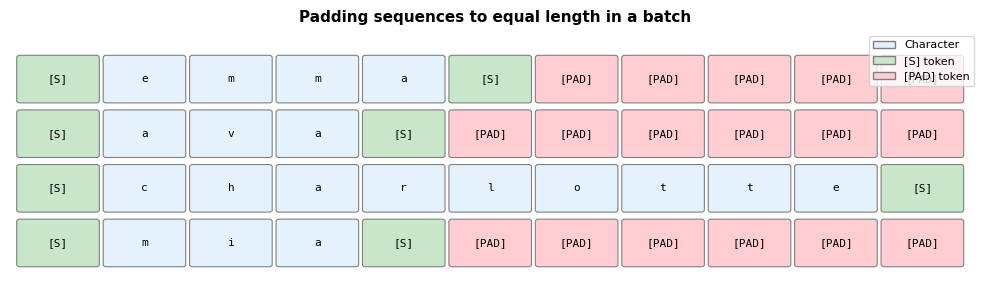

### Training the Language Model

Each epoch:
1. **Shuffle** the data (so batches are different each time)
2. For each **mini-batch**: pad sequences, run forward pass, compute cross-entropy loss (ignoring `[PAD]` positions), backpropagate, update weights
3. Evaluate on **validation set** to monitor overfitting (validation loss going up while training loss goes down)

We use the **Adam** optimiser, which adapts learning rates per-parameter.

In [11]:
import torch.optim as optim

model = RNNLM(vocab_size=len(token_to_index), hidden_size=96)
# Count model parameters
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

# Hyperparameters
learning_rate = 0.001
num_epochs = 10
batch_size = 16

# Loss function and optimizer
# NOTE: We ignore the loss whenever the target token is a padding token
criterion = nn.CrossEntropyLoss(ignore_index=token_to_index['[PAD]'])

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    # Reshuffle the data
    perm = torch.randperm(len(X_train))
    X_train = [X_train[i] for i in perm]
    Y_train = [Y_train[i] for i in perm]
    
    model.train()
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        Y_batch = Y_train[i:i+batch_size]
        X_batch, Y_batch = pad_batch(X_batch, Y_batch, token_to_index['[PAD]'])

        # Forward pass
        outputs, _ = model(X_batch) # [batch_size, seq_len, vocab_size]
        outputs = outputs.view(-1, len(token_to_index)) # [batch_size * seq_len, vocab_size]
        Y_batch = Y_batch.view(-1) # [batch_size * seq_len]
        loss = criterion(outputs, Y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / (len(X_train) // batch_size)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Evaluate validation loss
    eval_loss = 0
    model.eval()
    with torch.no_grad():
        for i in range(0, len(X_dev), batch_size):
            X_batch = X_dev[i:i+batch_size]
            Y_batch = Y_dev[i:i+batch_size]
            X_batch, Y_batch = pad_batch(X_batch, Y_batch, token_to_index['[PAD]'])

            outputs, _ = model(X_batch)
            outputs = outputs.view(-1, len(token_to_index))
            Y_batch = Y_batch.view(-1)
            loss = criterion(outputs, Y_batch)

            eval_loss += loss.item()
    avg_eval_loss = eval_loss / (len(X_dev) // batch_size)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_eval_loss:.4f}')


Model parameters: 24028
Epoch [1/10], Loss: 2.2388
Epoch [1/10], Validation Loss: 2.1729
Epoch [2/10], Loss: 2.1293
Epoch [2/10], Validation Loss: 2.1294
Epoch [3/10], Loss: 2.0934
Epoch [3/10], Validation Loss: 2.1101
Epoch [4/10], Loss: 2.0719
Epoch [4/10], Validation Loss: 2.0960
Epoch [5/10], Loss: 2.0552
Epoch [5/10], Validation Loss: 2.0843
Epoch [6/10], Loss: 2.0434
Epoch [6/10], Validation Loss: 2.0834
Epoch [7/10], Loss: 2.0328
Epoch [7/10], Validation Loss: 2.0788
Epoch [8/10], Loss: 2.0241
Epoch [8/10], Validation Loss: 2.0743
Epoch [9/10], Loss: 2.0172
Epoch [9/10], Validation Loss: 2.0696
Epoch [10/10], Loss: 2.0107
Epoch [10/10], Validation Loss: 2.0668


### Autoregressive Generation

Once trained, we generate names character by character:

1. Start with the `[S]` token
2. Feed it through the model to get a probability distribution over the next character
3. **Sample** a character from that distribution
4. Feed the sampled character back as the next input
5. Repeat until the model outputs `[S]` (stop) or we hit a maximum length

This is called **autoregressive** generation -- each output becomes the next input.

In [12]:
# Sample from the model
def sample(model, context, max_length=100):
    model.eval()
    output = []
    with torch.no_grad():
        x = torch.tensor([[token_to_index['[S]']] + context])
        hidden = None
        for _ in range(max_length):
            y, hidden = model(x, hidden)
            y = y[0, -1].softmax(dim=0)
            y = torch.multinomial(y, 1)
            token = index_to_token[y.item()]
            if token == '[S]':
                break
            output.append(token)
            x = y.view(1, 1)
    return ''.join(output)

In [13]:
for i in range(10):
    print(sample(model, []))

chelin
elys
emesecy
mattella
maxstin
lareon
ais
natami
romino
daraoe


In [14]:
prompt = 's'
for i in range(10):
    out = sample(model, [token_to_index[tok] for tok in prompt])
    print(prompt + out)

seedon
shrayan
senia
samar
shariah
shago
saneston
someiry
saraya
silver


### Suggested Exercises

1. Use `nn.RNN` instead of our `RNNCell`. Do you have to change anything in the implementation?
2. Change `nn.RNN` to `nn.GRU`. Do you have to change anything else in the implementation? Does the loss improve?
3. Change `nn.RNN` to `nn.LSTM`. Do you have to change anything else in the implementation? Does the loss improve?
4. Vary the hyperparameters (e.g., hidden size, batch size, learning rate, number of epochs). Can you find any consistent relationships between hyperparameter(s) and the loss?
5. When the validation loss begins to increase, and the training loss is decreasing, we have evidence of **overfitting**. Can you induce this overfitting by changing the hyperparameters?
6. Train a recurrent model on a more complex dataset. Use a tokenizer learned with BPE (either one that you train your own, or a pre-existing one).